In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
sns.set()

warnings.filterwarnings('ignore')

%matplotlib inline
color = sns.color_palette()

In [2]:
# Загрузка датасета
data = pd.read_excel('data_time_series.xlsx')
data.shape

(303, 2)

In [3]:
# Вывод первых пяти строк
data.head()

,Date,Value
0,1994-06-01,103527.0
1,1994-07-01,54521.0
2,1994-08-01,79458.0
3,1994-09-01,63093.0
4,1994-10-01,54376.0


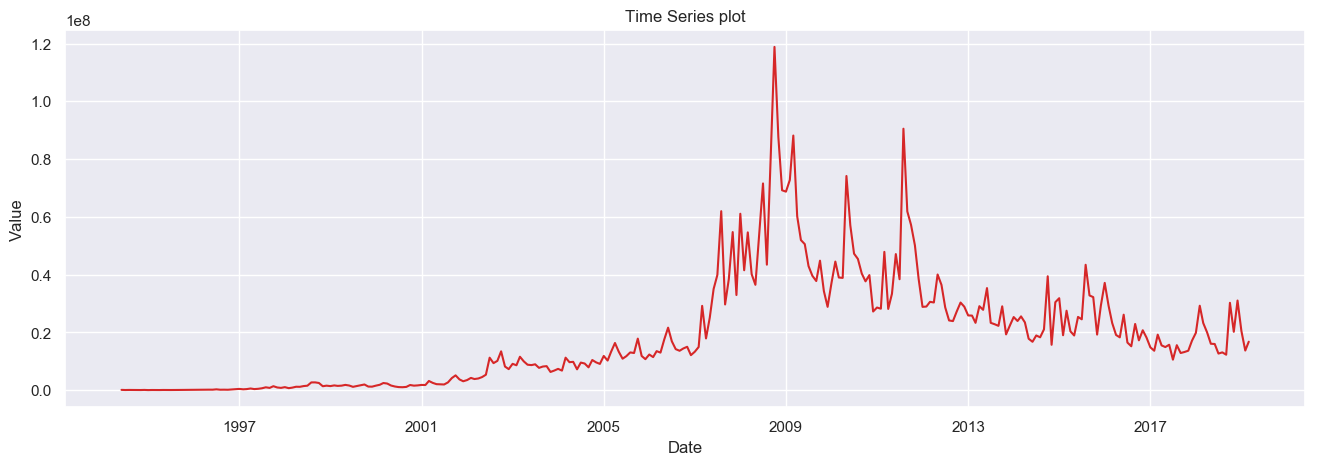

In [4]:
# Визуализировать данные
plt.figure(figsize=(16, 5), dpi=100)
plt.plot(data['Date'], data['Value'], color='tab:red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series plot')
plt.show()

In [5]:
# Проверяем ряд на стационарность
# ADF Test
result = adfuller(data.Value.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.75586598900075
p-value: 0.4025824960476023
Critial Values:
   1%, -3.4538376962008495
Critial Values:
   5%, -2.8718811911083093
Critial Values:
   10%, -2.5722803076202174


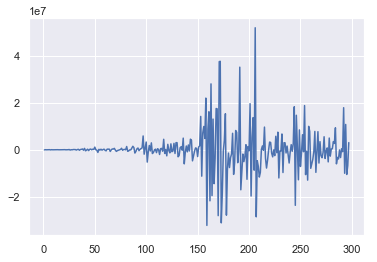

In [6]:
# P-value > 0.05 ---> Ряд не стационарный
# Проводим трансформации что бы сделать ряд стационарным
origin = data.copy()
data['Value'] = data['Value'] - data['Value'].shift(1)
data['Value'].dropna().plot()

In [7]:
# Проверяем ряд на стационарность
# ADF Test
result = adfuller(data.Value.dropna().values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# P-value < 0.05 ---> Ряд стационарный

ADF Statistic: -4.364499637697195
p-value: 0.00034284712752652576
Critial Values:
   1%, -3.4538376962008495
Critial Values:
   5%, -2.8718811911083093
Critial Values:
   10%, -2.5722803076202174


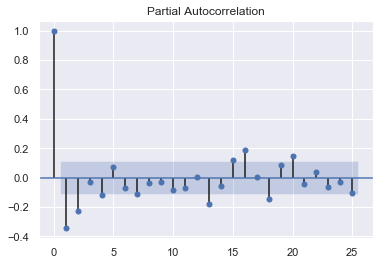

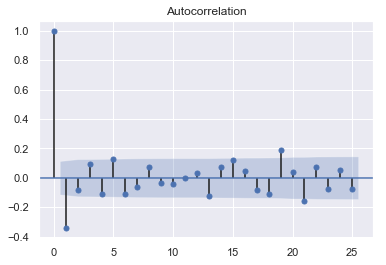

In [8]:
# Визуализация ЧАКФ
plot_pacf(data.Value.dropna().values)
plt.show()

# Визуализация АКФ
plot_acf(data.Value.dropna().values)
plt.show()


In [10]:
# Параметр для модели: p = 4
# Стороим модель: 
# p = 4; 
# d = 1 ---> в модель вставляем сырые, не дифф данные; 
# q = 0 ---> Чтобы использывать ARIMA как AR модель

# Сначала трансформируем данные
train_data = np.log(origin.Value.dropna().values)

model = ARIMA(train_data, order=(4,1,0))

In [11]:
# Получем остатки 
model = model.fit(disp=0)
print(model.aic)
residuals = model.resid
residuals

85.48982109755877


array([-6.59315178e-01,  1.21812637e-01, -1.86009041e-01, -2.25791573e-01,
       -3.16897058e-01,  5.14036328e-01, -9.88075865e-01,  3.30787581e-01,
       -1.37646145e-01, -5.20198064e-02,  2.65734936e-01,  5.66585773e-02,
       -1.31767752e-01,  3.31476913e-01,  8.58344262e-02,  1.44413595e-01,
        3.68250529e-02,  1.45046778e-01,  9.10279053e-02,  3.74192627e-01,
        3.67219414e-01, -1.00517192e-01,  9.25405246e-02,  2.48698556e-02,
        5.32006579e-01, -4.58163050e-01, -8.43092934e-02, -2.03089981e-01,
        4.46380613e-01,  4.34089598e-01,  4.16085549e-01, -2.51824167e-01,
        1.65701062e-01,  5.02212589e-01, -2.48392921e-01,  4.99516683e-02,
        3.82659857e-01,  5.82902244e-01, -9.41367773e-02,  5.47720676e-01,
       -1.54669224e-01, -2.26119640e-01,  1.26851604e-01, -2.92420279e-01,
        2.75583241e-03,  3.01424611e-01,  1.19056043e-01,  1.60578787e-01,
        1.87861391e-01,  6.24135344e-01,  2.16328632e-01,  5.54929173e-03,
       -6.17595374e-01, -

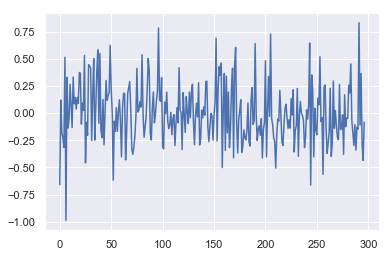

In [12]:
# Визуализировать остатки
plt.plot(residuals)
plt.show()

In [13]:
# Проверка на белый шум
acorr_ljungbox(residuals, lags=[1])

# P-value > 0.05 ---> остатки это белый шум

(array([0.00076392]), array([0.97795005]))

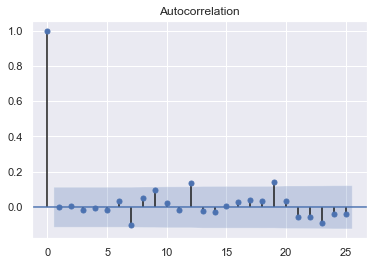

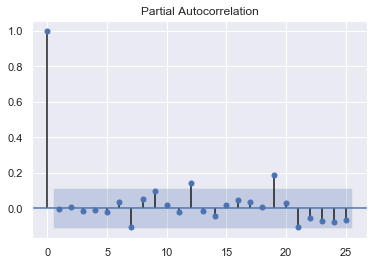

In [14]:
# Визуализация АКФ остатков
plot_acf(residuals)

# Визуализация ЧАКФ остатков
plot_pacf(residuals)
plt.show()

In [15]:
# Строим SARIMA модель и визуалзируем первое пропущенное значение
# Задаём параметры
param = (4, 1, 4)
param_seasonal = (2, 0, 2, 12)


# Создаём отдельную переменную для тренировки модели
d = origin.dropna()
df = pd.DataFrame(data=d.Date.values, columns=['Date'])
df['Value'] = train_data
df = df.set_index('Date')
print(df.head())

# Тренируем модель 
sarima_model = SARIMAX(df, order=param, seasonal_order=param_seasonal,
                       enforce_stationarity=False, enforce_invertibility=False) 
results = sarima_model.fit(disp=False)

# Смотрим результат
print('\n\n\nAIC:', results.aic)
results.summary()

                Value
Date                 
1994-06-01  11.547588
1994-07-01  10.906341
1994-08-01  11.282984
1994-09-01  11.052365
1994-10-01  10.903678



AIC: 58.575270955768694


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Value   No. Observations:                  298
Model:             SARIMAX(4, 1, 4)x(2, 0, 2, 12)   Log Likelihood                 -16.288
Date:                            Tue, 13 Aug 2019   AIC                             58.575
Time:                                    22:22:20   BIC                            105.258
Sample:                                06-01-1994   HQIC                            77.325
                                     - 03-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4979      0.348     -1.432      0.152      -1.180       0.184
ar.L2         -0.6471      0.155     -4.184      0.000      -0.950      -0.344
ar.L3          0.0998      0.235      0.424      0.671      -0.361       0.561
ar.L4          0.0797      0.186      0.428      0.669      -0.285       0.445
ma.L1          2.1093      2.040      1.034      0.301      -1.889       6.108
ma.L2         -0.0412      0.517     -0.080      0.937      -1.055       0.973
ma.L3          0.6462      1.203      0.537      0.591      -1.711       3.003
ma.L4         -1.6305      1.309     -1.246      0.213      -4.195       0.934
ar.S.L12       0.6151      0.145      4.239      0.000       0.331       0.899
ar.S.L24       0.1644      0.112      1.470      0.142      -0.055       0.384
ma.S.L12      -0.4746      0.167     -2.849      0.004      -0.801      -0.148
ma.S.L24      -0.1963      0.126     -1.561      0.119      -0.443       0.050
sigma2         0.0115      0.020      0.588      0.557      -0.027       0.050
===================================================================================
Ljung-Box (Q):                       34.55   Jarque-Bera (JB):                24.69
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.71
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

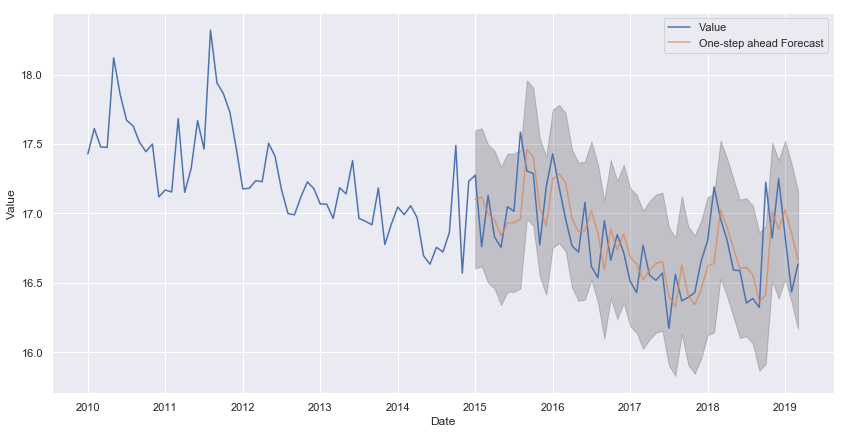

First missing value forecast:  2019-04-01    1.492748e+07
Freq: MS, dtype: float64


In [16]:
# Оцениваем точность модели и визуализируем результат
# Выбираем отрезок для тестового предсказания - от '2015-01-01'
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2010-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Делаем предсказание для первого пропущенного значения
preds = results.predict(start=pd.to_datetime('2019-04-01'))
print('First missing value forecast: ', np.exp(preds))

In [17]:
# Проверяем модель на точность предсказания
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(df['1994-01-01':].values, pred.predicted_mean.values)

11.149183529343231

In [18]:
# Предсказуем все пропущенные значения в датасете
# Ищем пропущенные значения
missing_values = origin.isnull()
missing_values.sum()

Date     0
Value    5
dtype: int64

In [19]:
# Находим даты, значения которых нужно предсказать 
missing_indexes = np.nonzero(missing_values.Value.values)
missing_dates = origin.Date.iloc[missing_indexes]
missing_dates.values

array(['2019-04-01T00:00:00.000000000', '2019-05-01T00:00:00.000000000',
       '2019-06-01T00:00:00.000000000', '2019-07-01T00:00:00.000000000',
       '2019-08-01T00:00:00.000000000'], dtype='datetime64[ns]')

            lower Value  upper Value
2019-04-01    16.021116    17.016313
            lower Value  upper Value
2019-05-01    15.937129    17.134342
            lower Value  upper Value
2019-06-01    16.027364    17.384813
            lower Value  upper Value
2019-07-01    15.819619     17.27211
            lower Value  upper Value
2019-08-01     15.78259    17.276908
                  Min        Max   Forecast
2019-04-01  16.021116  17.016313  16.518714
2019-05-01  15.937129  17.134342  16.535735
2019-06-01  16.027364  17.384813  16.706088
2019-07-01  15.819619  17.272110  16.545864
2019-08-01  15.782590  17.276908  16.529749


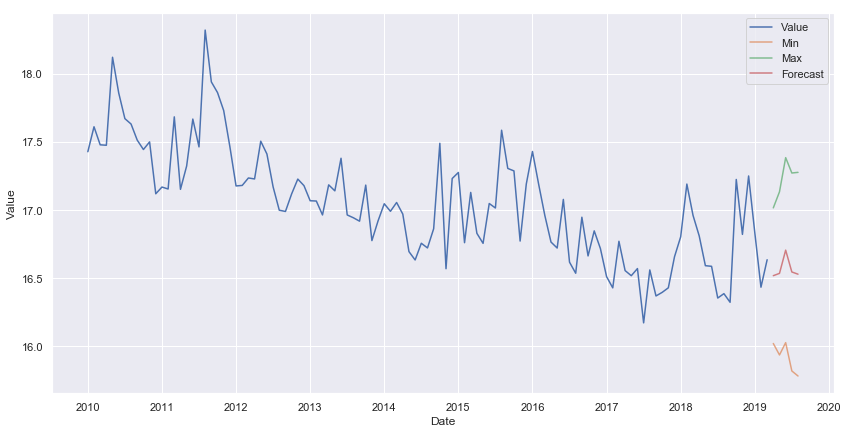

In [20]:
# Создаём пустой датафрэйм
predictions = pd.DataFrame(columns=['Min', 'Max', 'Forecast'])

# Делаем предсказания пропущенных значений
for missing in missing_dates:
    pred = results.get_prediction(start=pd.to_datetime(missing), dynamic=False)
    pred_ci = pred.conf_int()
    print(pred_ci)
    
    # Выдлеяем ответ в виде доверительных интервалов и рассчитуем среднее значение
    prediction = pd.DataFrame(data={'Min': pred_ci['lower Value'].values, 'Max': pred_ci['upper Value'].values}, 
                              index=pred_ci.index)
    prediction['Forecast'] = (prediction['Min'].values + prediction['Max'].values) / 2
    predictions = predictions.append(prediction, ignore_index=False)

print(predictions)

# Наносим предсказанные значения на график вместе с реальными значениями
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2010-01-01':].plot(label='observed')
# Визуализируем среднее значения и его интервалы
predictions.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [21]:
# Сохраняем данные в файл
print(np.exp(predictions.Forecast))
res = predictions.copy()
res['Date'] = res.index.values
res['Date'] = res['Date'].dt.date 
res = res.set_index('Date')
res.index.name = 'Date'
res['Forecast'] = np.exp(res.Forecast.values)
res['Min'] = np.exp(res.Min.values)
res['Max'] = np.exp(res.Max.values)
res.to_excel('predictions.xlsx')

2019-04-01    1.492748e+07
2019-05-01    1.518373e+07
2019-06-01    1.800371e+07
2019-07-01    1.533831e+07
2019-08-01    1.509311e+07
Name: Forecast, dtype: float64
